# Satellite Land Cover completeness for Spatial Planning and Land Management

Production date: 22-10-2024

Produced by: Luís Figueiredo e Inês Girão (+ATLANTIC)

## 🌍 Use case: Using land cover products to monitor Land Cover (LC) changes

## ❓ Quality assessment question
* **How consistent with other datasets are satellite observations in capturing land cover changes, such as urbanisation?**

Land cover data is a vital resource across a wide range of fields, from climate change research to urban and regional planning. Products with long historical timelines allow scientists, policymakers, and planners to assess how land use and land cover have evolved over time, supporting evidence-based decision-making.

In this notebook, we use the ***Land Cover Classification Gridded Maps from 1992 to present derived from satellite observations*** (hereafter referred to as **LC**) provided by the Climate Data Store (CDS) of the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/esotc/2023). The analysis focuses on evaluating the consistency of C3S-derived settlement (Artificial Land) classes with independent statistical records from **EUROSTAT**, across selected years and NUTS2 regions in the Iberian Peninsula.


## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset demonstrates physical consistency and precision among the different datasets as it aligns closely with equivalent statistics from official sources [(EUROSTAT,2025)](https://ec.europa.eu/eurostat/databrowser/bookmark/63d3fd90-2f5b-4bec-99f3-4f88814e2624?lang=en). Specifically, the analysis shows that the Urban/Settlements category closely matches EUROSTAT's statistics for the Artificial Land category in the most populated NUTs 2 regions. Differences are typically small, within 0.3–5% absolute difference for the majority of regions and years assessed.

* Beyond the scope of this analysis, additional work could examine whether the dataset aligns with findings reported in peer-reviewed studies, such as [Fernández-Nogueira and Corbelle-Rico (2018)](https://doi.org/10.1016/j.apgeog.2009.07.003). This would help validate the robustness and reliability of the dataset through comparison with multiple datasets.

* Another aspect of the analysis supporting the dataset's precision is the identification of trade-offs between urban expansion and the decline of agricultural areas, a well-documented phenomenon. Numerous studies, including observations across multiple European regions, note that urban growth frequently replaces agricultural lands [Bagan and Yamagata (2014)](https://doi.org/10.1088/1748-9326/9/6/064015).

```

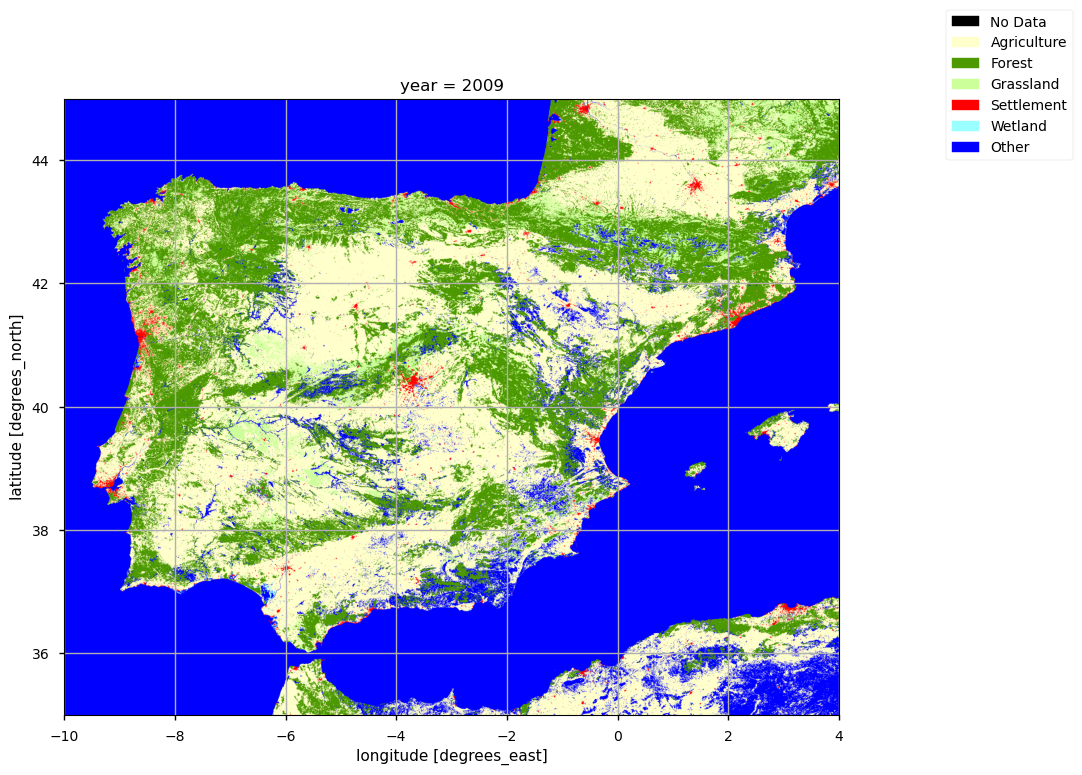

## 📋 Methodology

**[](code-section-1)**

**[](code-section-2)**

**[](code-section-3)**

**[](code-section-4)**

**[](code-section-5)**

## 📈 Analysis and results

(code-section-1)=
### 1. Define the AoI, search and download LC data.

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [1]:
import geopandas as gpd # import vector geospatial data
import pandas as pd
import matplotlib.pyplot as plt # plot graphs
import matplotlib.patches as patches 
import numpy as np # perform trigonometric calculations
import shapely.geometry # work with geometric shapes
import regionmask # transform attributes and geometries into specific regions
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils 
from shapely.vectorized import contains
import dask.array as da
import plotly.graph_objects as go
import plotly.io as pio

plt.style.use("seaborn-v0_8-notebook") # predifined style of all graphical outputs
pio.renderers.default = "notebook"

#### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu Here you can search for 'Satellite observations land' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the [Global Climate Observing System(GCOS) convention requirements](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245).  These Land Cover (LC) maps correspond to a global classification scheme encompassing 22 land cover classes.

**Note:** Although the dataset is officially described as having 22 global land cover classes, many of these classes are internally subdivided into more detailed subcategories (e.g., types of cropland, forest canopy structure, types of shrubland). These subdivisions allow for greater ecological detail but can be aggregated back into the 22 main classes for standard analysis and intercomparison purposes.

Data specifications for this use case:
- **Years:** 2009, 2012, 2015, 2018 and 2022
- **Versions:** v2.0.7 for years up to 2015; v2.1.1 for 2018
- **Format:** Downloaded as .zip files

At the end of the data request form on CDS, select `Show API request` to generate Python code, which can be pasted directly into a Jupyter Notebook cell. Running this cell will retrieve the requested files, provided that you have accepted the dataset's `terms and conditions` on the CDS platform. It is advisable to define the desired time period and Area of Interest (AoI) explicitly when preparing the API request, as shown in the example cells below.


In [2]:
#Years to download
years = [2009,2012,2015,2018,2022]

In [3]:
# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2_0_7cds" if year < 2016 else "v2_1_1",
        "year": str(year),
        "area": [45, -10, 35, 4] # Region of interest (Iberian Peninsula)
    }
    for year in years
]

In [4]:
# Download and regionalize by AoI
ds = download.download_and_transform(
    collection_id,
    requests,
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")


100%|██████████| 5/5 [00:00<00:00,  5.96it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning:

In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.

/data/wp5/.tmp/ipykernel_744325/3410308190.py:6: DeprecationWarning:

dropping variables using `drop` is deprecated; use drop_vars.

/data/wp5/.tmp/ipykernel_744325/217959964.py:29: RuntimeWarning:

invalid value encountered in cast

/data/wp5/.tmp/ipykernel_744325/217959964.py:29: RuntimeWarning:

invalid value encountered in cast



(code-section-2)=
### 2. Inspect and view data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an xarray.

#### Label Color Definition and Class Correspondence

To facilitate visual inspection of the Land Cover (LC) classes, we define a dictionary containing each class label (the "keys"), the corresponding color code (the "colors"), and the associated numeric identifier (the "values"). In addition, we create a second dictionary to establish the correspondence between the original land cover classes provided in the metadata and the aggregated IPCC classes, as described in the Product User Guide (see resources).


In [5]:
# Define LC labels dictionary
keys = ds.lccs_class.flag_meanings.split()
colors = ds.lccs_class.flag_colors.split()
element = "#000000"
colors.insert(0, element)
values = ds.lccs_class.flag_values

lccs_dict = {key: (color, value) for key, color, value in zip(keys, colors, values)}

# Helper function to format the labels text
def format_key(key):
    return key.replace("_", " ").title()

lccs_dict = {format_key(key): value for key, value in lccs_dict.items()}
lccs_dict

{'No Data': ('#000000', np.uint8(0)),
 'Cropland Rainfed': ('#ffff64', np.uint8(10)),
 'Cropland Rainfed Herbaceous Cover': ('#ffff64', np.uint8(11)),
 'Cropland Rainfed Tree Or Shrub Cover': ('#ffff00', np.uint8(12)),
 'Cropland Irrigated': ('#aaf0f0', np.uint8(20)),
 'Mosaic Cropland': ('#dcf064', np.uint8(30)),
 'Mosaic Natural Vegetation': ('#c8c864', np.uint8(40)),
 'Tree Broadleaved Evergreen Closed To Open': ('#006400', np.uint8(50)),
 'Tree Broadleaved Deciduous Closed To Open': ('#00a000', np.uint8(60)),
 'Tree Broadleaved Deciduous Closed': ('#00a000', np.uint8(61)),
 'Tree Broadleaved Deciduous Open': ('#aac800', np.uint8(62)),
 'Tree Needleleaved Evergreen Closed To Open': ('#003c00', np.uint8(70)),
 'Tree Needleleaved Evergreen Closed': ('#003c00', np.uint8(71)),
 'Tree Needleleaved Evergreen Open': ('#005000', np.uint8(72)),
 'Tree Needleleaved Deciduous Closed To Open': ('#285000', np.uint8(80)),
 'Tree Needleleaved Deciduous Closed': ('#285000', np.uint8(81)),
 'Tree Ne

In [6]:
# Define IPCC labels dictionary
ipcc_dict = {
    "No Data": ("#000000", [0]),
    "Agriculture": ("#ffffcc", [10, 11, 12, 20, 30, 40]),
    "Forest": ("#4c9900", [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]),
    "Grassland": ("#ccff99", [110, 130]),
    "Settlement": ("#ff0000", [190]),
    "Wetland": ("#99ffff", [180]),
    "Other": ("#0000ff", [120, 121, 122, 140, 150, 151, 152, 153, 200, 201, 202, 210]),
}

ipcc_dict 

{'No Data': ('#000000', [0]),
 'Agriculture': ('#ffffcc', [10, 11, 12, 20, 30, 40]),
 'Forest': ('#4c9900',
  [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]),
 'Grassland': ('#ccff99', [110, 130]),
 'Settlement': ('#ff0000', [190]),
 'Wetland': ('#99ffff', [180]),
 'Other': ('#0000ff',
  [120, 121, 122, 140, 150, 151, 152, 153, 200, 201, 202, 210])}

#### Plot maps

Having defined the color and legends for the IPCC classes and using the metadata of the dataset to get the colors and legends for each Land Cover class it is now possible to plot our data either with the original colors or with the IPCC previously defined colors.

The function below plots the LC maps for the year of your choice , using both land cover schemes. From the output, we can already distinguish the differences in classification schemes. 

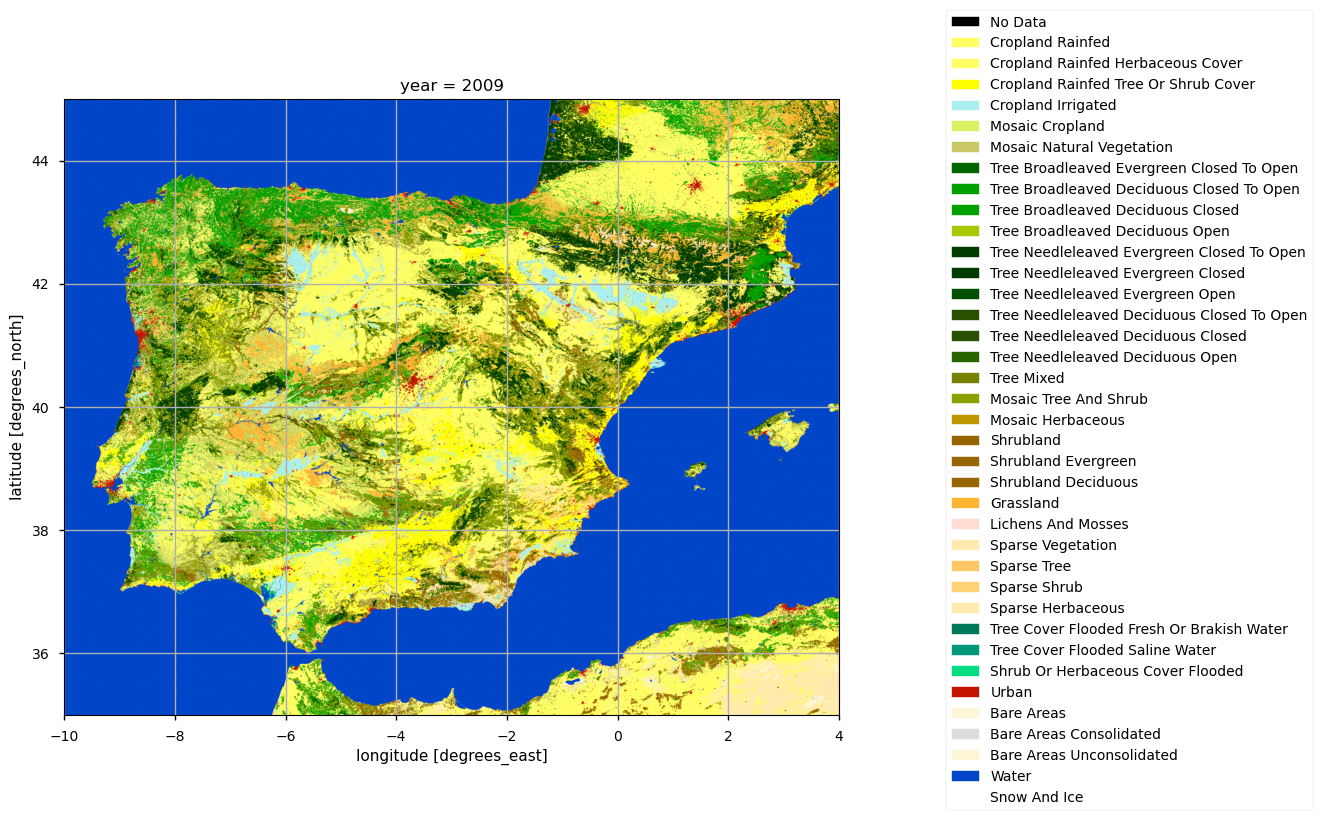

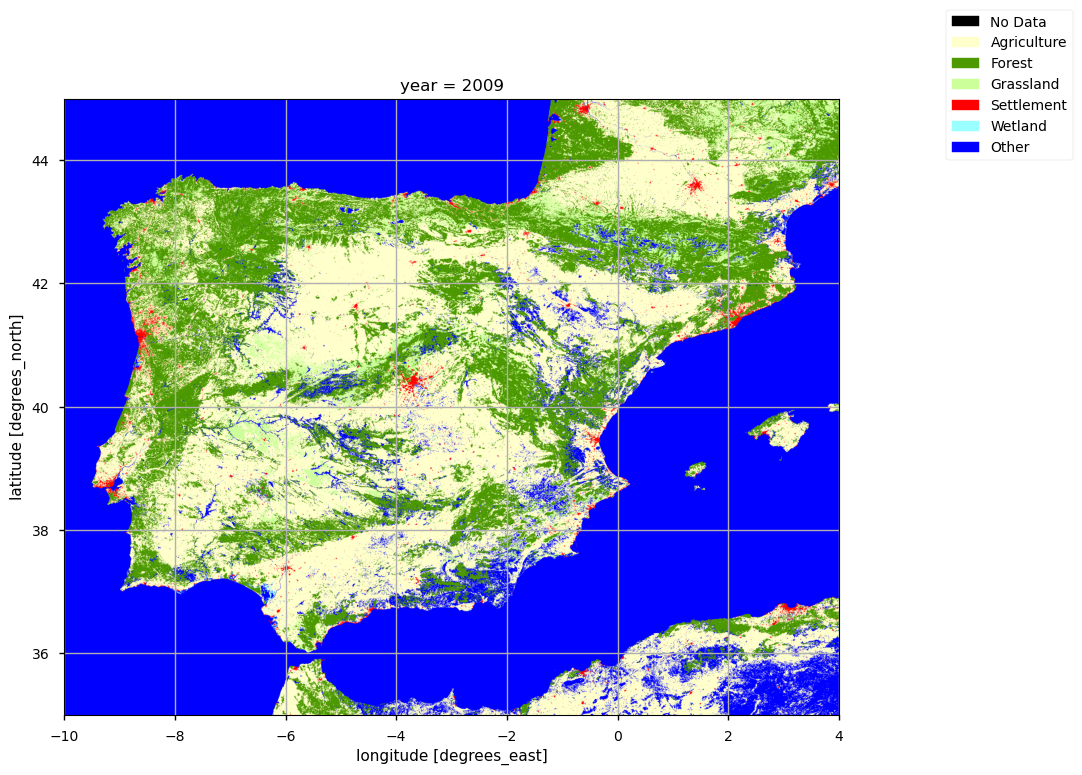

In [7]:
selected_year = 2009  # choose the year you want

# Filter the dataset for the selected year
lccs_selected = ds["lccs_class"].sel(year=selected_year)

# Adjust the size of the figure and legend to make maps bigger and the legend smaller
for legend_dict in [None, ipcc_dict]:
    plot.lccs_map(
        lccs_selected,
        legend_dict=legend_dict,
        interpolation="antialiased",
        figsize=(10, 8)  # Set the figure size 
    )
    plt.show()


(code-section-3)=
### 3. Calculate total area and area percentage of change in for AoI by LC classes

To further identify changes in LC patterns, in this user question, Nomenclature of Territorial Units for Statistics (NUTS) 2 will be used, providing the information regarding the main regions/parcels of the Iberian Peninsula.

The [NUTS](https://ec.europa.eu/eurostat/web/nuts) are a hierarchical system divided into 3 levels. NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correspond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 


The step below masks the Land Cover data according to the NUTS 2 boundaries and calculates the area of each pixel (weighted by Latitude). For each NUTS 2 region, we proceed with the analysis and visual inspection of Land Cover areas per class and corresponding percentages during the selected period.

#### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [8]:
# Shapefile with regions (NUTS2)
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip" #NUTS2 download path

In [9]:
# Define the CRS for the Iberian Peninsula (WGS84)
crs = "epsg:4326"  # EPSG code for WGS84 (latitude/longitude)

# Data filter: load the shapefile and filter for NUTS2 regions in Spain and Portugal
gdf = gpd.read_file(shapefile_url)  # Read the shapefile NUTS2
gdf = gdf[gdf["LEVL_CODE"] == 2]  # Keep only features at the second administrative level (NUTS2)
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]  # Keep only NUTS2 regions for Spain (ES) and Portugal (PT)
gdf = gdf.to_crs(crs)  # Ensure CRS is consistent with the dataset

# Create a mask for the NUTS2 regions that intersect with the Iberian Peninsula
regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")  # Create regions mask based on GeoPandas DataFrame

# Apply the mask to the dataset
mask = regions.mask(ds["longitude"], ds["latitude"])

# Only keep land areas (not ocean) by applying the mask
# This ensures that only land pixels are used in the area calculations
ds = ds.where(mask.notnull(), drop=True)  # Drop ocean pixels that are outside the NUTS2 regions

#### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by Latitude).

[If you want to know more](https://rdrr.io/cran/raster/man/area.html) 

In [10]:
# Calculate Pixel Area after applying the mask
scaling_factor = 0.002778  # Define a scaling factor for conversion
resolution_km = scaling_factor * 111.195  # Calculate the grid cell resolution in kilometers
indexes = xr.DataArray(range(ds.sizes["latitude"]), dims="latitude")  # Create an array of latitude indexes
lats = ds["latitude"].max() - indexes * scaling_factor
grid_cell_area = resolution_km**2 * np.cos(np.radians(lats))
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Area",
    "units": "km2",
}
ds = ds.assign_coords(cell_area=grid_cell_area)

#### Bar Charts - Iberian Peninsula

Having the area calculated and the NUTS 2 regions assigned to each pixel, we can now proceed to create the plots of the LC areas per class, by year. First, let's inspect the total area of each LC class in this AoI. We will use the original LC classes to highlight which ones have more significant changes.

In [11]:
#Fuction to calculate class area with original classes
def calculate_area_by_class(ds, cell_area, year):
    # Select the data for the given year
    ds_year = ds.sel(year=year)
    
    # Initialize a dictionary to store the area for each land cover class
    area_by_class = {}
    
    # Loop over each unique land cover class (lccs_class)
    for lc_class in np.unique(ds_year['lccs_class'].values):
        # Create a mask for the current LC class
        mask = ds_year['lccs_class'] == lc_class
        
        # Calculate the total area for the current LC class
        total_area = cell_area.where(mask).sum().compute()  # Use .compute() to get the result
        area_by_class[lc_class] = total_area
    
    return area_by_class

# Calculate areas for 1992 and 2022
area_2009 = calculate_area_by_class(ds, ds["cell_area"], 2009)
area_2012 = calculate_area_by_class(ds, ds["cell_area"], 2012)
area_2015 = calculate_area_by_class(ds, ds["cell_area"], 2015)
area_2018 = calculate_area_by_class(ds, ds["cell_area"], 2018)
area_2022 = calculate_area_by_class(ds, ds["cell_area"], 2022)

/data/wp5/.tmp/ipykernel_744325/217959964.py:29: RuntimeWarning:

invalid value encountered in cast

/data/wp5/.tmp/ipykernel_744325/217959964.py:29: RuntimeWarning:

invalid value encountered in cast



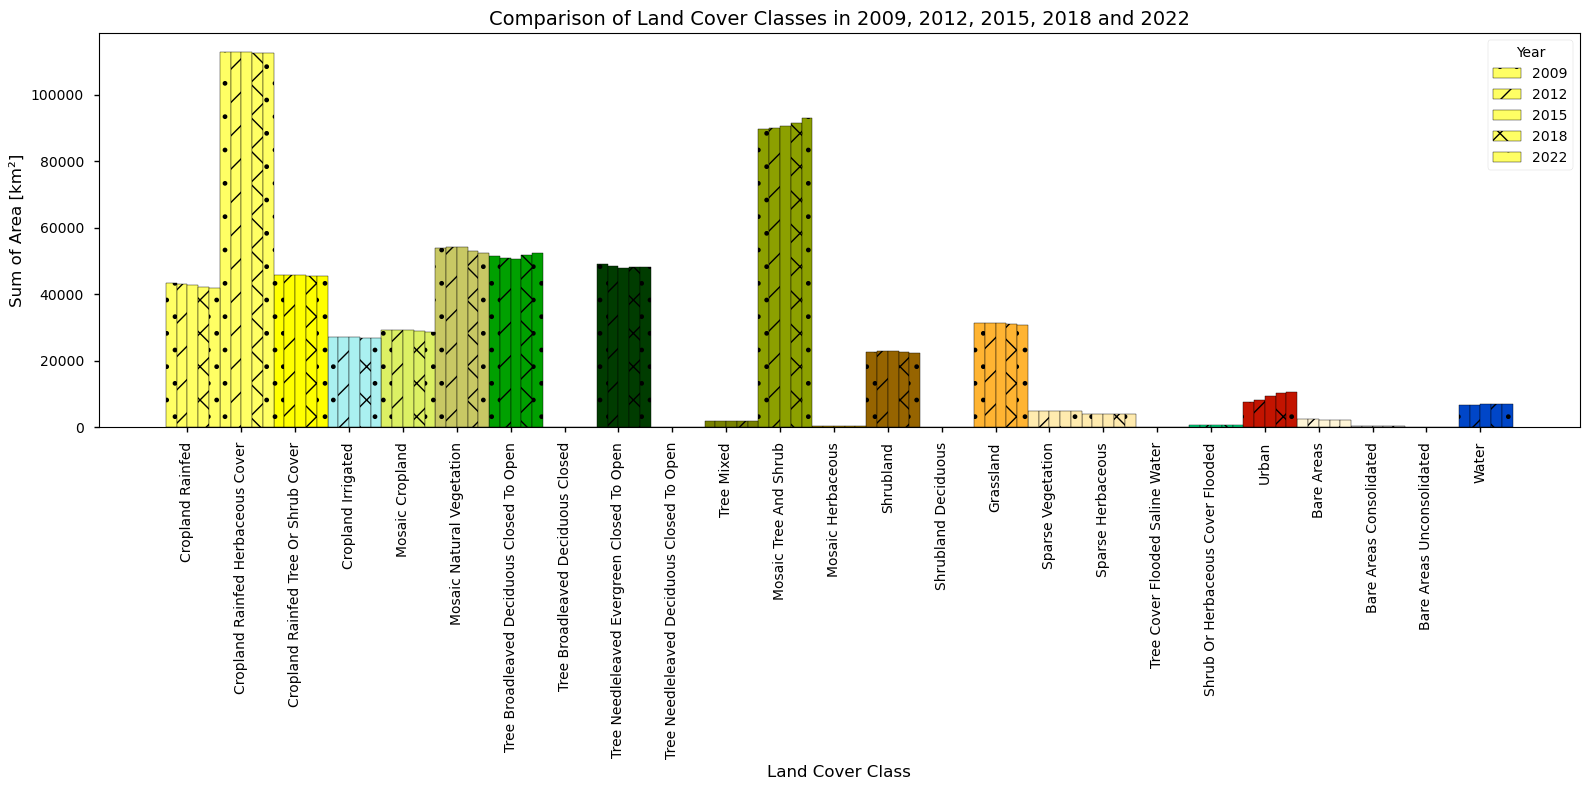

In [12]:
# Combine area dictionaries into a single dictionary
area_by_year = {
    2009: area_2009,
    2012: area_2012,
    2015: area_2015,
    2018: area_2018,
    2022: area_2022
}

# Ensure lc_classes excludes NaN
lc_classes = [lc_class for lc_class in np.unique(ds["lccs_class"].values) if not np.isnan(lc_class)]

# Prepare area lists for plotting
area_lists = {
    year: [area_by_year[year].get(lc_class, 0) for lc_class in lc_classes]
    for year in area_by_year
}

# Get class names and colors from the mapping dictionaries
numeric_to_name = {value[1]: key for key, value in lccs_dict.items()}
numeric_to_color = {value[1]: value[0] for key, value in lccs_dict.items()}
class_names = [numeric_to_name.get(int(lc_class), 'Unknown') for lc_class in lc_classes]
colors = [numeric_to_color.get(int(lc_class), '#000000') for lc_class in lc_classes]

# Bar plot settings
bar_width = 0.2
index = np.arange(len(lc_classes))
plt.figure(figsize=(16, 8))

# Unique hatching patterns for visual separation by year
hatch_patterns = {
    2009: '.',
    2012: '/',
    2015: '',
    2018: 'x',
    2022: '.'
}

# Plot bars for each year
for i, year in enumerate(sorted(area_by_year)):
    plt.bar(
        index + i * bar_width,
        area_lists[year],
        bar_width,
        label=str(year),
        color=colors,
        edgecolor='black',
        alpha=1,
        hatch=hatch_patterns[year]
    )

# Final plot customization
plt.xlabel('Land Cover Class', fontsize=12)
plt.ylabel('Sum of Area [km²]', fontsize=12)
plt.title('Comparison of Land Cover Classes in 2009, 2012, 2015, 2018 and 2022', fontsize=14)
plt.xticks(index + bar_width * 1.5, class_names, rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

In [13]:
# Consecutive transitions only: 2009→2012, 2012→2015, 2015→2018 

INCLUDE_NODATA_IN_GROUPS = False   # include "No Data" in grouped matrices?
NODATA_CODE = 0                    # lccs no_data code to exclude

lccs = ds["lccs_class"]
years = ds["year"].values.astype(int).tolist()
year_pairs = list(zip(years[:-1], years[1:]))

# Broadcast cell_area (latitude) -> (latitude, longitude); km² weights
area_km2_2d = ds["cell_area"].broadcast_like(lccs.isel(year=0))

# Class codes from ds attributes; exclude NODATA_CODE
all_codes = lccs.flag_values.astype(int)
valid_classes = np.array(sorted([int(c) for c in all_codes if int(c) != NODATA_CODE]), dtype=np.int64)
nC = valid_classes.size
max_code = int(all_codes.max())

# Build LUT (raw code -> contiguous index)
lut = -np.ones(max_code + 1, dtype=np.int16)
lut[valid_classes] = np.arange(nC, dtype=np.int16)


# Safe mapping function (handles NaN / invalid codes)

def _map_codes_to_idx(a_da, lut, max_code):
    def _map_block(block, lut=lut, max_code=max_code):
        invalid = ~np.isfinite(block)
        xi = block.astype(np.int64, copy=False)
        invalid |= (xi < 0) | (xi > max_code)
        out = np.full(block.shape, -1, dtype=np.int16)
        if (~invalid).any():
            xi_valid = xi[~invalid].astype(np.int64, copy=False)
            out[~invalid] = lut[xi_valid]
        return out
    return da.map_blocks(_map_block, a_da, dtype=np.int16)


# Weighted transition per pair (fast, dask-based)

def pair_transition_matrix(y0, y1):
    a0 = lccs.sel(year=y0).data
    a1 = lccs.sel(year=y1).data
    w  = area_km2_2d.data

    idx0 = _map_codes_to_idx(a0, lut, max_code)
    idx1 = _map_codes_to_idx(a1, lut, max_code)

    valid = (idx0 >= 0) & (idx1 >= 0) & da.isfinite(w) & (w > 0)
    i0 = da.where(valid, idx0, -1).ravel()
    i1 = da.where(valid, idx1, -1).ravel()
    ww = da.where(valid, w, 0.0).ravel()

    flat = i0.astype(np.int64) * nC + i1.astype(np.int64)
    flat = da.where(i0 >= 0, flat, -1)
    sel = flat >= 0
    flat_valid = flat[sel]
    w_valid    = ww[sel]

    bc = da.bincount(flat_valid, weights=w_valid, minlength=nC * nC)
    C = bc.reshape((nC, nC)).compute()  # km²

    return xr.DataArray(
        C,
        coords={"from_class": valid_classes, "to_class": valid_classes},
        dims=("from_class", "to_class"),
        name=f"transitions_{y0}_{y1}_km2",
    )

# Compute 3 class→class matrices (km²)
transitions_km2 = { (y0, y1): pair_transition_matrix(y0, y1) for (y0, y1) in year_pairs }
# Percent versions
transitions_pct = { k: (v / float(v.sum()) * 100.0) if float(v.sum())>0 else (v*0.0) for k,v in transitions_km2.items() }

# ----------------------------
# Aggregate to IPCC groups
# ----------------------------
class_to_group = {}
ipcc_groups_order = []
for g, (_col, codes) in ipcc_dict.items():
    if g == "No Data" and not INCLUDE_NODATA_IN_GROUPS:
        continue
    ipcc_groups_order.append(g)
    for c in codes:
        class_to_group[int(c)] = g

nG = len(ipcc_groups_order)
M = np.zeros((nC, nG), dtype=np.float64)
code_to_idx = {int(c): i for i, c in enumerate(valid_classes)}
for j, g in enumerate(ipcc_groups_order):
    for c in ipcc_dict[g][1]:
        ci = code_to_idx.get(int(c))
        if ci is not None:
            M[ci, j] = 1.0

def aggregate_to_ipcc(C_da):
    G_np = M.T @ C_da.values @ M
    return xr.DataArray(
        G_np,
        coords={"from_group": ipcc_groups_order, "to_group": ipcc_groups_order},
        dims=("from_group", "to_group"),
        name=C_da.name.replace("_km2", "_km2_ipcc"),
    )

transitions_km2_ipcc = {k: aggregate_to_ipcc(v) for k,v in transitions_km2.items()}
transitions_pct_ipcc  = {
    k: xr.DataArray(
        (v.values / float(v.values.sum()) * 100.0) if float(v.values.sum())>0 else (v.values*0.0),
        coords=v.coords, dims=v.dims, name=v.name.replace("_km2_ipcc","_pct_ipcc")
    )
    for k,v in transitions_km2_ipcc.items()
}

# Tidy long tables

def to_long_df(mat_da, y0, y1, idx_name, col_name, units):
    df = mat_da.to_pandas()
    df.index.name = idx_name
    df.columns.name = col_name
    long = df.stack().reset_index()
    long.columns = [idx_name, col_name, "Value"]
    long.insert(0, "From Year", y0)
    long.insert(1, "To Year", y1)
    long["Units"] = units
    return long

ipcc_km2_parts = [to_long_df(v, y0, y1, "From Group", "To Group", "km²") for (y0,y1),v in transitions_km2_ipcc.items()]
ipcc_pct_parts = [to_long_df(v, y0, y1, "From Group", "To Group", "%")   for (y0,y1),v in transitions_pct_ipcc.items()]
ipcc_km2_long = pd.concat(ipcc_km2_parts, ignore_index=True) if ipcc_km2_parts else pd.DataFrame()
ipcc_pct_long = pd.concat(ipcc_pct_parts, ignore_index=True) if ipcc_pct_parts else pd.DataFrame()


In [14]:
def plot_ipcc_sankey_best(
    pair,
    G_km2_dict,
    ignore_self=True,
    min_value_km2=0.0,
    title_suffix=""
):

    y0, y1 = pair
    G = G_km2_dict.get(pair)
    if G is None:
        print(f"[warn] No matrix for pair {pair}")
        return

    # Base arrays
    A = G.values.astype(float)  # km²
    rows = list(G.coords["from_group"].values)
    cols = list(G.coords["to_group"].values)
    n = len(rows)

    # Denominators
    if ignore_self:
        A_den = A.copy()
        np.fill_diagonal(A_den, 0.0)
    else:
        A_den = A

    total_all = A_den.sum()
    row_sums  = A_den.sum(axis=1, keepdims=True)

    # Build links
    sources, targets, values, hover = [], [], [], []
    for i, src in enumerate(rows):
        for j, dst in enumerate(cols):
            if ignore_self and src == dst:
                continue
            km2 = A[i, j]
            if not np.isfinite(km2) or km2 <= min_value_km2:
                continue

            pct_global = (km2 / total_all * 100.0) if total_all > 0 else 0.0
            pct_row    = (km2 / row_sums[i, 0] * 100.0) if row_sums[i, 0] > 0 else 0.0

            sources.append(i)
            targets.append(n + j)
            values.append(km2)
            hover.append(
                f"{src} → {dst}<br>"
                f"{km2:,.1f} km²  |  {pct_global:.2f}% of non-self transitions  |  {pct_row:.2f}% of {src} outflow"
            )

    if not values:
        print(f"[warn] No non-self transitions above {min_value_km2} km² for {pair}")
        return

    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(label=rows + cols, pad=15, thickness=20, line=dict(color="black", width=0.5)),
        link=dict(source=sources, target=targets, value=values,
                  hovertemplate="%{customdata}<extra></extra>", customdata=hover),
    ))
    ttl = f"LC Transitions {y0}→{y1}"
    if title_suffix:
        ttl += f" — {title_suffix}"
    fig.update_layout(title_text=ttl, font_size=12, width=900, height=600)

    # Instead of showing directly:
    return fig



In [15]:
for pair in [(2009, 2012), (2012, 2015), (2015, 2018), (2018, 2022)]:
    fig = plot_ipcc_sankey_best(pair, transitions_km2_ipcc)
    if fig:
        fig.show()

#### Plot Analysis

The bar chart above compares the total land cover class areas across four years: 2009, 2012, 2015, 2018 and 2022. The most notable trend is the steady increase in the 'Urban' class over time, reflecting ongoing urbanisation in the Iberian Peninsula. Although the total area classified as 'Urban' remains relatively small compared to other categories, it shows a consistent upward trajectory across the four years.

The sankey diagrams show that from 2009 to 2022, the land cover transitions reveal a steady and persistent increase in settlement areas. Early in the period (2009–2015), most new settlements emerged from agricultural land, reflecting urban expansion and infrastructure development at the expense of cropland. Between 2015 and 2018, this trend continued but at a slower pace, as some agricultural areas transitioned toward forest recovery. By 2018–2022, settlement growth remained evident, still primarily converting former agricultural and “other” land classes, though representing a smaller share of total land changes.

(code-section-4)=
### 4. Calculate the area percentage and the area percentage change for the most populated regions

Having identified general urbanisation trends in the Iberian Peninsula, we now focus on specific NUTS2 regions in greater detail. These regions were selected based on their inclusion of the largest urban areas in terms of population, according to the Urban Audit Indicators dataset from the European Commission (Eurostat).

The selected NUTS2 regions are:

- **Comunidad de Madrid**, which includes the city of Madrid (5,098,717 inhabitants in 2022), the capital of Spain;
- **Cataluña**, which includes Barcelona (3,755,512 inhabitants in 2022);
- **Área Metropolitana de Lisboa**, which includes Lisbon (1,872,036 inhabitants in 2022), the capital of Portugal;
- **Comunitat Valenciana**, which includes Valencia (1,417,464 inhabitants in 2022);
- **Norte**, which includes Porto (955,864 inhabitants in 2022).

For each of these regions, we analyse land cover dynamics in terms of **area percentages by IPCC classes**, in order to highlight broader, aggregated land cover changes. Additionally, we compare dataset results with EUROSTAT statistics to assess the consistency between datasets.


#### Calculation of the percentage area, absolute change, and relative percentage change for each IPCC class category

1. **Area Percentage Coverage**:  
   *Example*: In 1992, forest land covered 35% of the total area, while urban areas occupied 10%. By 2022, forest coverage decreased to 30%, and urban areas expanded to 15%. This metric gives the proportion of the total land occupied by each land cover class.

2. **Absolute Percentage Difference**:  
   *Example*: In 1992, 10% of the region was classified as agricultural land. By 2022, this had decreased to 8%. The absolute percentage difference in agricultural land coverage is −2% (from 10% in 1992 to 8% in 2022, representing a 2% decrease in total land area occupied by agriculture).

3. **Relative Percentage Difference**:  
   *Example*: In 1992, 10% of the area was classified as wetlands. By 2022, wetlands accounted for 12% of the total area. The relative percentage difference is calculated as ((12−10)/10)∗100 = +20%. This means there was a 20% increase in wetland area relative to its size in 1992.

In [16]:
# Filter the GeoDataFrame to include only the regions of interest
regions= ["Comunidad de Madrid", "Cataluña", "Área Metropolitana de Lisboa", "Comunitat Valenciana", "Norte"]

gdf_filtered = gdf[gdf['NUTS_NAME'].isin(regions)]
gdf_filtered = gdf_filtered.to_crs("EPSG:4326")

# Expand cell_area ONCE outside the loops
cell_area = ds["cell_area"].expand_dims({"longitude": ds.sizes["longitude"]}, axis=1)

# Prepare latitude and longitude grids ONCE
lat, lon = ds['latitude'].values, ds['longitude'].values
lon_grid, lat_grid = np.meshgrid(lon, lat)  # avoid recalculating inside mask function

In [17]:
# Create region mask using shapely
def create_region_mask(region_geom, lon_grid, lat_grid):
    points = [shapely.geometry.Point(x, y) for x, y in zip(lon_grid.ravel(), lat_grid.ravel())]
    mask = np.array([region_geom.contains(pt) for pt in points]).reshape(lon_grid.shape)
    return xr.DataArray(mask, coords=[lat, lon], dims=["latitude", "longitude"])

# Calculate IPCC class % coverage for a given year and region
def calculate_ipcc_coverage(year, region_mask, cell_area, ipcc_dict, total_area):
    lccs = ds["lccs_class"].sel(year=year).where(region_mask)
    return {
        group: ((xr.where(np.isin(lccs, codes), 1, 0) * cell_area).sum().item() / total_area) * 100
        for group, (_, codes) in ipcc_dict.items()
    }

# Compute absolute and relative differences
def compute_differences(base, target):
    abs_diff = {k: target[k] - base[k] for k in base}
    rel_diff = {k: ((target[k] - base[k]) / base[k]) * 100 if base[k] else 0 for k in base}
    return abs_diff, rel_diff

# Padded y-axis limits
def padded_limits(values, pad=0.1):
    finite_vals = [v for v in values if np.isfinite(v)]
    if not finite_vals: return 0, 1
    min_v, max_v = min(finite_vals), max(finite_vals)
    return min_v, max_v + (max_v - min_v) * pad

In [18]:
# Plot area coverage (bar chart comparing 2009 and 2022)
def plot_coverage(ax, cov_2009, cov_2022, region, ymax):
    labels = [k for k in cov_2009 if k != 'No Data']
    x = np.arange(len(labels))
    width = 0.35
    colors = [ipcc_dict[k][0] for k in labels]
    y1 = [cov_2009[k] for k in labels]
    y2 = [cov_2022[k] for k in labels]

    ax.bar(x - width/2, y1, width, color=colors, edgecolor='black', label='2009')
    ax.bar(x + width/2, y2, width, color=colors, edgecolor='black', hatch='//', label='2022')
    ax.set_ylabel('Coverage Area (%)')
    ax.set_title(f'"{region}" NUTS2')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0, ymax)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

# Plot absolute and relative differences (side-by-side bars)
def plot_differences(ax1, ax2, abs_d, rel_d, region, lims_abs, lims_rel):
    labels = [k for k in abs_d if k != 'No Data']
    x = np.arange(len(labels))
    width = 0.35
    colors = [ipcc_dict[k][0] for k in labels]

    # Absolute difference
    ax1.bar(x, [abs_d[k] for k in labels], width, color=colors, edgecolor='black')
    ax1.set_ylabel('Absolute Change (%)')
    ax1.set_title(f'Abs Diff "{region}"')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylim(*lims_abs)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Relative difference
    ax2.bar(x, [rel_d[k] for k in labels], width, color=colors, edgecolor='black')
    ax2.set_ylabel('Relative Change (%)')
    ax2.set_title(f'Rel Diff "{region}"')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylim(*lims_rel)
    ax2.grid(True, linestyle='--', alpha=0.6)



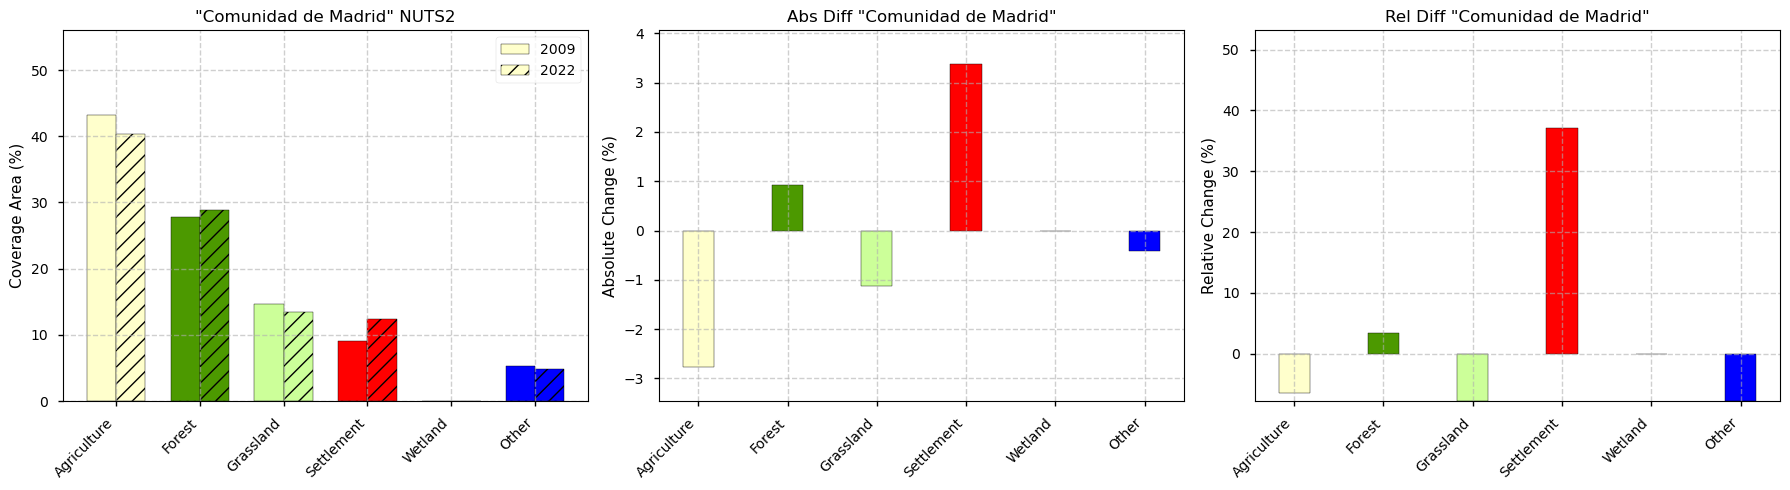

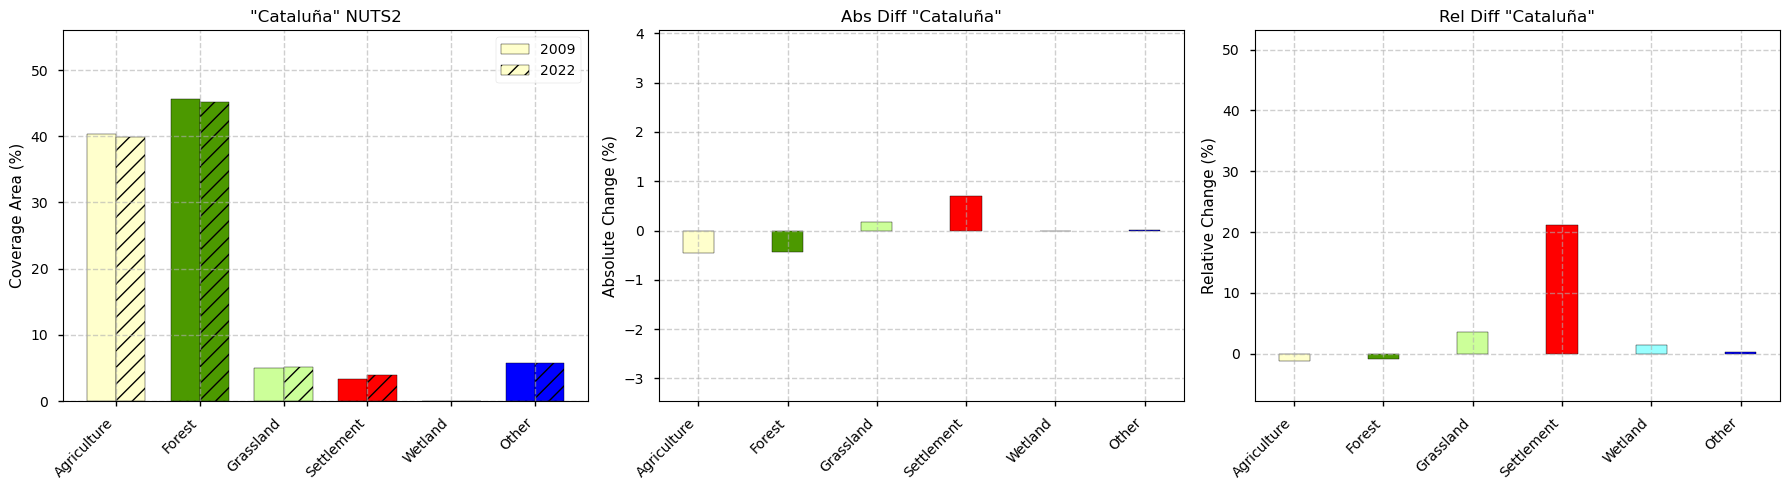

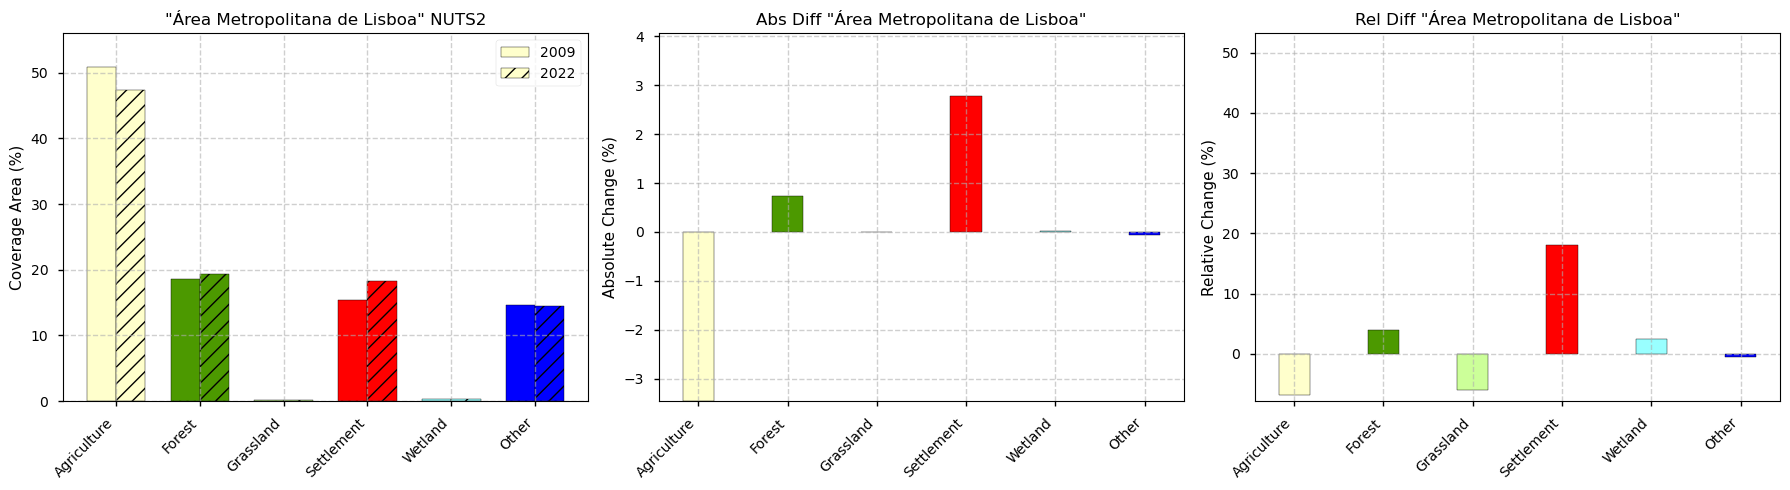

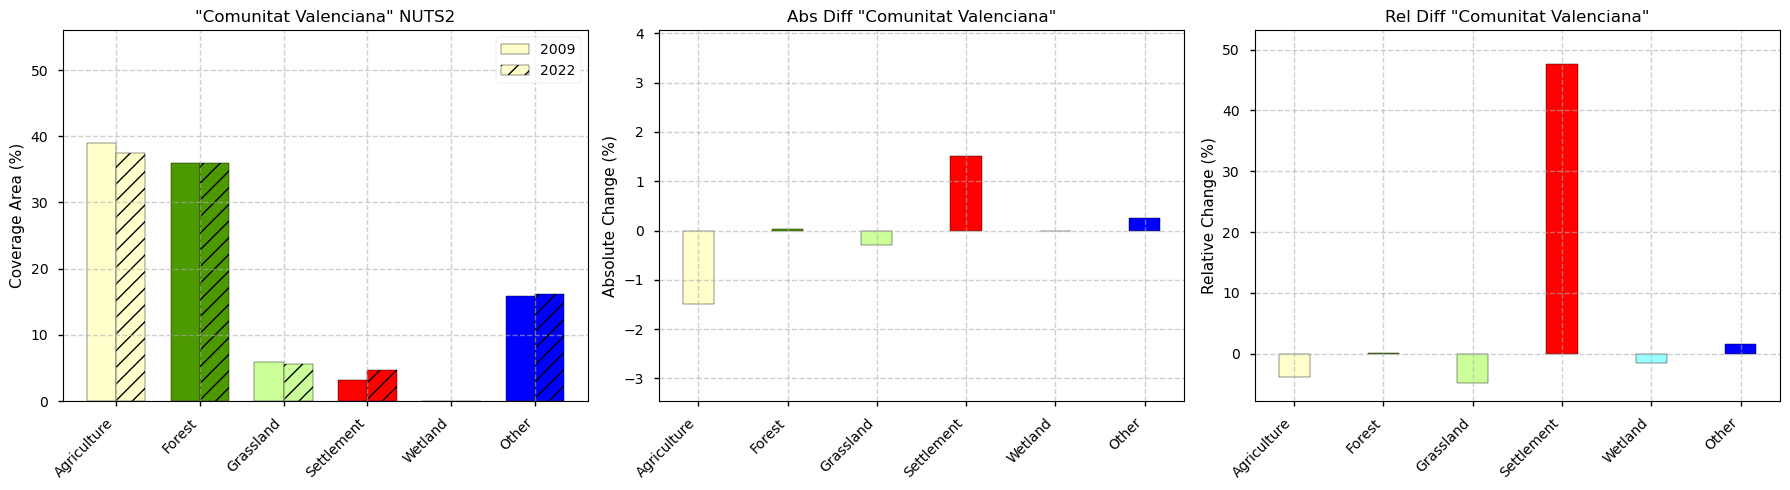

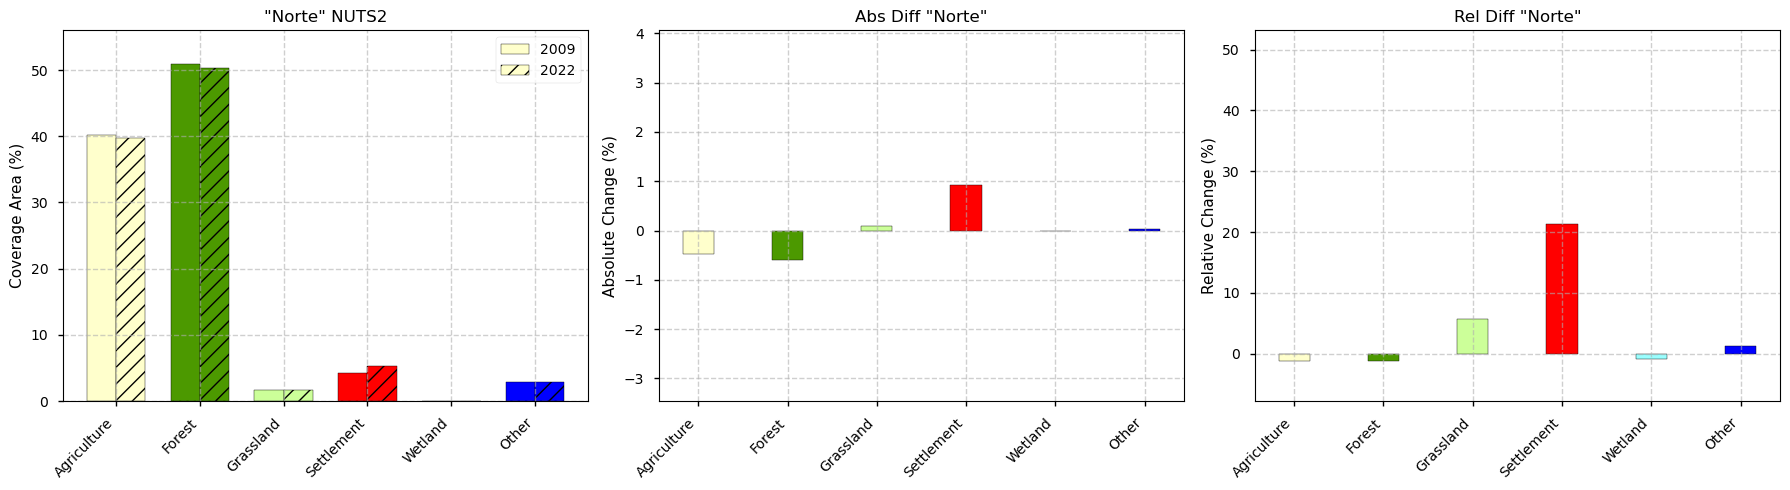

In [19]:
# Preprocessing
years_to_check = [2009, 2012, 2015, 2018,2022]
global_cov, global_abs, global_rel = [], [], []

# Storage dictionary for later reuse
all_coverages = {}  # (region, year) -> coverage dict

# Calculate everything
for region in regions:
    geom = gdf_filtered[gdf_filtered["NUTS_NAME"] == region].geometry.union_all()
    mask = create_region_mask(geom, lon_grid, lat_grid)
    total_area = (mask * cell_area).sum().item()
    if total_area == 0:
        continue

    for year in years_to_check:
        cov = calculate_ipcc_coverage(year, mask, cell_area, ipcc_dict, total_area)
        all_coverages[(region, year)] = cov

    # For plotting (only cov_2009 vs cov_2022)
    cov_2009 = all_coverages[(region, 2009)]
    cov_2022 = all_coverages[(region, 2022)]
    abs_d, rel_d = compute_differences(cov_2009, cov_2022)

    global_cov.extend(list(cov_2009.values()) + list(cov_2022.values()))
    global_abs.extend(abs_d.values())
    global_rel.extend(rel_d.values())

# Calculate global plot limits
lims_cov = padded_limits(global_cov)
lims_abs = padded_limits(global_abs)
lims_rel = padded_limits(global_rel)


# Plot results
for region in regions:
    cov_2009 = all_coverages[(region, 2009)]
    cov_2022 = all_coverages[(region, 2022)]
    abs_d, rel_d = compute_differences(cov_2009, cov_2022)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    plot_coverage(ax1, cov_2009, cov_2022, region, lims_cov[1])
    plot_differences(ax2, ax3, abs_d, rel_d, region, lims_abs, lims_rel)
    plt.tight_layout()
    plt.show()

#### **Bar Chart Analysis**

Across the five most populated NUTS2 regions clear land cover change patterns are observed between 2009 and 2018, especially in relation to urban expansion and agricultural decline.

- **Settlement/Urban areas** show a consistent and significant increase in all regions, with the most pronounced growth occurring in Área Metropolitana de Lisboa and Comunidad de Madrid. 

- **Agricultural land** has decreased across all regions, with the sharpest reduction seen in Área Metropolitana de Lisboa. The decline appears moderate in Comunidad de Madrid, Cataluña, and Comunitat Valenciana, suggesting a gradual conversion of agricultural land to urban or other uses.

- **Forest and grassland areas** remained mostly stable in several regions, with small increases in Comunitat Valenciana and Cataluña, indicating preservation or limited natural regeneration in non‑urbanised areas. However, in Norte and Valencia, forest cover declined despite only a minimal change of agricultural land. This pattern suggests that the reduction in forest area is linked to the expansion of settlements.

- **Wetlands and other land cover categories** continue to represent a negligible share of total area. Their relative and absolute changes are minimal, with little to no impact on the overall land use structure of the regions.

These trends are consistent with well-documented urbanisation dynamics in Southern Europe, where urban growth often occurs at the expense of agricultural land. The dataset captures these patterns clearly, supporting its reliability for regional land cover monitoring.


#### Comparison with EUROSTAT Data

To validate the consistency of the dataset, we compared the percentage of land classified as "Settlement" against the values for artificial land reported by [EUROSTAT](https://ec.europa.eu/eurostat/databrowser/view/lan_lcv_ovw/default/table?lang=en&category=lan). The table below shows values for the five most populated NUTS2 regions in the Iberian Peninsula for the four EUROSTAT available years.

While these datasets differ in classification methodology, temporal resolution, and source data, the values are comparable in magnitude. This alignment supports the conclusion that the C3S dataset is broadly consistent with other authoritative sources for regional monitoring of urbanisation.



In [20]:
# EUROSTAT reference values (percent)

eurostat_artificial = {
    ("Área Metropolitana de Lisboa", 2009): 14.6,
    ("Área Metropolitana de Lisboa", 2012): 15.4,
    ("Área Metropolitana de Lisboa", 2015): 15.8,
    ("Área Metropolitana de Lisboa", 2018): 18.9,
    ("Área Metropolitana de Lisboa", 2022): 17.7,
    ("Comunidad de Madrid", 2009): 9.7,
    ("Comunidad de Madrid", 2012): 10.1,
    ("Comunidad de Madrid", 2015): 10.6,
    ("Comunidad de Madrid", 2018): 11.7,
    ("Comunidad de Madrid", 2022): 11.5,
    ("Cataluña", 2009): 6.3,
    ("Cataluña", 2012): 6.4,
    ("Cataluña", 2015): 6.5,
    ("Cataluña", 2018): 5.3,
    ("Cataluña", 2022): 5.9,
    ("Comunitat Valenciana", 2009): 6.1,
    ("Comunitat Valenciana", 2012): 6.2,
    ("Comunitat Valenciana", 2015): 6.5,
    ("Comunitat Valenciana", 2018): 7.2,
    ("Comunitat Valenciana", 2022): 6.9,
    ("Norte", 2009): 6.8,
    ("Norte", 2012): 6.9,
    ("Norte", 2015): 7.0,
    ("Norte", 2018): 9.4,
    ("Norte", 2022): 8.0,
}

eurostat_woodland = {
    ("Área Metropolitana de Lisboa", 2009): 11.4,
    ("Área Metropolitana de Lisboa", 2012): 22.1,
    ("Área Metropolitana de Lisboa", 2015): 23.2,
    ("Área Metropolitana de Lisboa", 2018): 28.1,
    ("Área Metropolitana de Lisboa", 2022): 24.5,
    ("Comunidad de Madrid", 2009): 15.3,
    ("Comunidad de Madrid", 2012): 20.1,
    ("Comunidad de Madrid", 2015): 24.1,
    ("Comunidad de Madrid", 2018): 30.6,
    ("Comunidad de Madrid", 2022): 32.1,
    ("Cataluña", 2009): 41.5,
    ("Cataluña", 2012): 44.8,
    ("Cataluña", 2015): 44.8,
    ("Cataluña", 2018): 49.6,
    ("Cataluña", 2022): 48.2,
    ("Comunitat Valenciana", 2009): 23.4,
    ("Comunitat Valenciana", 2012): 29.2,
    ("Comunitat Valenciana", 2015): 29.8,
    ("Comunitat Valenciana", 2018): 35.5,
    ("Comunitat Valenciana", 2022): 34.0,
    ("Norte", 2009): 22.6,
    ("Norte", 2012): 24.1,
    ("Norte", 2015): 26.1,
    ("Norte", 2018): 28.9,
    ("Norte", 2022): 26.7,
}

eurostat_grassland = {
    ("Área Metropolitana de Lisboa", 2009): 21.4,
    ("Área Metropolitana de Lisboa", 2012): 25.7,
    ("Área Metropolitana de Lisboa", 2015): 22.7,
    ("Área Metropolitana de Lisboa", 2018): 16.5,
    ("Área Metropolitana de Lisboa", 2022): 22.2,
    ("Comunidad de Madrid", 2009): 25.3,
    ("Comunidad de Madrid", 2012): 24.4,
    ("Comunidad de Madrid", 2015): 24.9,
    ("Comunidad de Madrid", 2018): 20.4,
    ("Comunidad de Madrid", 2022): 17.9,
    ("Cataluña", 2009): 13.1,
    ("Cataluña", 2012): 12.8,
    ("Cataluña", 2015): 13.4,
    ("Cataluña", 2018): 8.9,
    ("Cataluña", 2022): 9.2,
    ("Comunitat Valenciana", 2009): 13.4,
    ("Comunitat Valenciana", 2012): 14.1,
    ("Comunitat Valenciana", 2015): 14.0,
    ("Comunitat Valenciana", 2018): 5.6,
    ("Comunitat Valenciana", 2022): 6.6,
    ("Norte", 2009): 17.7,
    ("Norte", 2012): 18.2,
    ("Norte", 2015): 16.9,
    ("Norte", 2018): 14.3,
    ("Norte", 2022): 13.3,
}

eurostat_cropland = {
    ("Área Metropolitana de Lisboa", 2009): 18.5,
    ("Área Metropolitana de Lisboa", 2012): 14.9,
    ("Área Metropolitana de Lisboa", 2015): 13.6,
    ("Área Metropolitana de Lisboa", 2018): 17.4,
    ("Área Metropolitana de Lisboa", 2022): 15.9,
    ("Comunidad de Madrid", 2009): 15.5,
    ("Comunidad de Madrid", 2012): 14.0,
    ("Comunidad de Madrid", 2015): 15.6,
    ("Comunidad de Madrid", 2018): 17.7,
    ("Comunidad de Madrid", 2022): 15.1,
    ("Cataluña", 2009): 21.7,
    ("Cataluña", 2012): 19.5,
    ("Cataluña", 2015): 18.4,
    ("Cataluña", 2018): 24.4,
    ("Cataluña", 2022): 19.9,
    ("Comunitat Valenciana", 2009): 11.4,
    ("Comunitat Valenciana", 2012): 14.0,
    ("Comunitat Valenciana", 2015): 12.2,
    ("Comunitat Valenciana", 2018): 25.8,
    ("Comunitat Valenciana", 2022): 25.6,
    ("Norte", 2009): 14.0,
    ("Norte", 2012): 12.2,
    ("Norte", 2015): 11.5,
    ("Norte", 2018): 18.0,
    ("Norte", 2022): 19.1,
}


# Combined table for all classes and years

def eu_get(d, region, year):
    return d.get((region, int(year)), None)

rows = []
for region in regions:
    for year in years_to_check:
        cov = all_coverages.get((region, year))
        if cov is None:
            continue

        row = {
            "Region": region,
            "Year": int(year),
            "C3S Settlement (%)": cov.get("Settlement"),
            "EUROSTAT Artificial (%)": eu_get(eurostat_artificial, region, year),
            "Δ Settlement (%)": None if (cov.get("Settlement") is None or eu_get(eurostat_artificial, region, year) is None)
                                else cov["Settlement"] - eu_get(eurostat_artificial, region, year),
            "C3S Forest (%)": cov.get("Forest"),
            "EUROSTAT Woodland (%)": eu_get(eurostat_woodland, region, year),
            "Δ Forest (%)": None if (cov.get("Forest") is None or eu_get(eurostat_woodland, region, year) is None)
                              else cov["Forest"] - eu_get(eurostat_woodland, region, year),
            "C3S Grassland (%)": cov.get("Grassland"),
            "EUROSTAT Grassland (%)": eu_get(eurostat_grassland, region, year),
            "Δ Grassland (%)": None if (cov.get("Grassland") is None or eu_get(eurostat_grassland, region, year) is None)
                                 else cov["Grassland"] - eu_get(eurostat_grassland, region, year),
            "C3S Agriculture (%)": cov.get("Agriculture"),
            "EUROSTAT Cropland (%)": eu_get(eurostat_cropland, region, year),
            "Δ Agriculture (%)": None if (cov.get("Agriculture") is None or eu_get(eurostat_cropland, region, year) is None)
                                  else cov["Agriculture"] - eu_get(eurostat_cropland, region, year),
        }
        rows.append(row)

df_combined = pd.DataFrame(rows).sort_values(["Region", "Year"]).reset_index(drop=True)

pd.set_option("display.max_rows", None)
print(df_combined.round(2).to_string(index=False))


                      Region  Year  C3S Settlement (%)  EUROSTAT Artificial (%)  Δ Settlement (%)  C3S Forest (%)  EUROSTAT Woodland (%)  Δ Forest (%)  C3S Grassland (%)  EUROSTAT Grassland (%)  Δ Grassland (%)  C3S Agriculture (%)  EUROSTAT Cropland (%)  Δ Agriculture (%)
                    Cataluña  2009                3.29                      6.3             -3.01           45.66                   41.5          4.16               4.98                    13.1            -8.12                40.30                   21.7              18.60
                    Cataluña  2012                3.49                      6.4             -2.91           45.52                   44.8          0.72               4.99                    12.8            -7.81                40.21                   19.5              20.71
                    Cataluña  2015                3.71                      6.5             -2.79           45.42                   44.8          0.62               5.01         

(code-section-5)=
### 5. Main Takeaways


- The dataset demonstrates physical consistency with official sources, aligning well with [EUROSTAT statistics](https://ec.europa.eu/eurostat/databrowser/bookmark/63d3fd90-2f5b-4bec-99f3-4f88814e2624?lang=en) and findings from [Feranec et al. (2010)](https://doi.org/10.1016/j.apgeog.2009.07.003) and [Fernández-Nogueira & Corbelle-Rico (2018)](https://doi.org/10.3390/land7030099). Between 2009 and 2022, significant urbanisation occurred across major NUTS2 regions, with settlement areas doubling in some cases. This expansion largely came at the expense of Agriculture and Grassland classes. These patterns align with broader European trends identified by [Alberti et al. (2019)](https://publications.jrc.ec.europa.eu/repository/handle/JRC116711) using the GHSL dataset. Small discrepancies (<5%) with EUROSTAT are observed in artificial land, but they do not compromise the dataset’s reliability for identifying overall trends in land-use change, though users focusing on very localised patterns should interpret results with some caution.  

- Urban expansion mainly replaced agricultural and open land, while Forest areas remained largely stable. Settlements now occupy a larger share of the land but still cover less than 20% in most regions. These findings are consistent with spatial trade-off patterns reported by [Bagan & Yamagata (2014)](https://doi.org/10.1088/1748-9326/9/6/064015), where urban growth frequently takes from agricultural lands.

- The use of both detailed and aggregated IPCC classes provided a comprehensive view of land cover trends, balancing precision and generalization. Although class aggregation introduces some uncertainties (e.g., between Agriculture and Grassland), it enables clearer identification of dominant land transitions like urban expansion.

- Minor classification differences between datasets (e.g., how mixed-use or greenhouse areas are coded) can introduce uncertainties. Nonetheless, the dataset maintains high accuracy and precision in identifying urban expansion trends, consistent with findings by [Zhao et al (2023)](https://www.mdpi.com/2072-4292/15/9/2285).


## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:
* Land cover classification gridded maps from 1992 to present derived from satellite observations:
    (https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview)

* Product User Guide and Specification of the dataset [version 2.1](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf) and [version 2.0](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D3.3.11-v1.0_PUGS_CDR_LC-CCI_v2.0.7cds_Products_v1.0.1_APPROVED_Ver1.pdf) 


Additional resources:
* [Eurostat NUTS](https://ec.europa.eu/eurostat/web/nuts) (Nomenclature of territorial units for statistics)


Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)




### References

[Feranec, J., Jaffrain, G., Soukup, T., & Hazeu, G. (2010). Determining changes and flows in European landscapes 1990–2000 using CORINE land cover data. Applied geography, 30(1), 19-35.](https://doi.org/10.1016/j.apgeog.2009.07.003) 

[Fernández-Nogueira, D., & Corbelle-Rico, E. (2018). Land use changes in Iberian Peninsula 1990–2012. Land, 7(3), 99.](https://doi.org/10.3390/land7030099) 

[Eurostat, Statistical Atlas](https://ec.europa.eu/statistical-atlas/viewer/?ch=gridvizChapter&mids=BKGCNT,totalPop21,CNTOVL&o=1,1,0.7&center=40.94812,-2.2287,5&lcis=totalPop21&) 

[Bagan, H., & Yamagata, Y. (2014). Land-cover change analysis in 50 global cities by using a combination of Landsat data and analysis of grid cells. Environmental Research Letters, 9.](https://doi.org/10.1088/1748-9326/9/6/064015) 

[Alberti, V. et al (2019) The Future of Cities, Vandecasteele, I., Baranzelli, C., Siragusa, A. and Aurambout, J. editor(s), EUR 29752 EN, Publications Office of the European Union, Luxembourg, 2019, ISBN 978-92-76-03847-4, doi:10.2760/375209, JRC116711.](https://publications.jrc.ec.europa.eu/repository/handle/JRC116711)

[Zhao, T., Zhang, X., Gao, Y., Mi, J., Liu, W., Wang, J., Jiang, M., & Liu, L. (2023). Assessing the Accuracy and Consistency of Six Fine-Resolution Global Land Cover Products Using a Novel Stratified Random Sampling Validation Dataset. Remote. Sens., 15, 2285.](https://www.mdpi.com/2072-4292/15/9/2285) 